In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import os
import sys


## Set Device

In [12]:
device = torch.device(f'cuda' 
                      if torch.cuda.is_available()
                      else 'cpu')

print(device)

cpu


## Get Model

In [13]:
from runet_torch import runet

model = runet().to(device)
print(model)

runet(
  (enc1): EncoderBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): EncoderBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): EncoderBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc4): EncoderBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc5): EncoderBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride

## Custom Dataset

In [14]:
# Define dataset
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file_path):
        self.hf_r = h5py.File(hdf5_file_path, 'r')
        self.data_x = self.hf_r['k']
        self.data_y = self.hf_r['S']

    def __len__(self):
        return self.data_x.shape[0]  # Assuming N is the first dimension

    def __getitem__(self, idx):
        sample_x = self.data_x[idx, :, :, :]  # Extract a single item for k
        sample_y = self.data_y[idx, :, :, :]  # Extract the corresponding item for S

        
        #sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y
    
    def transform(sample_x, sample_y):
        sample_x = np.transpose(sample_x, (2, 3, 0, 1))
        sample_y = np.transpose(sample_x, (2, 3, 0, 1))
        return sample_x, sample_y


## Loss function

In [15]:
def mean_plume_error_loss(prediction, target):
    # Calculate the absolute difference
    abs_diff = torch.abs(prediction - target)

    # Create a mask for non-zero values in the target
    non_zero_mask = target != 0

    # Find non zero pixels n for each sample in batch
    N_target_nonzero = torch.sum(non_zero_mask, dim=(1, 2, 3))

    # Calculate the mean plume error for each sample in the batch
    mpe_per_sample = torch.sum(abs_diff, dim=(1, 2, 3)) / N_target_nonzero

    # Average the mean plume error across the batch
    mean_mpe = torch.mean(mpe_per_sample)

    return mean_mpe

def root_mse(mse_loss):
    return torch.sqrt(torch.tensor(mse_loss))

## Test

In [16]:
# Create instances of dataset and dataloaders
data_dir = './'

# Test / Validation
test_dataset = HDF5Dataset(data_dir + 'test_30400_reshaped.hdf5')

# Initialize loss function
criterion = nn.MSELoss()


In [17]:
# Load data
inputs, targets = test_dataset[:10]
        
inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
targets = torch.tensor(targets, dtype=torch.float32).to(device)


# Set weight .pth file
weights_path = 'work_dirs/epoch_0.pth'

# Load the state dict from the file
state_dict = torch.load(weights_path)

# Load the state dict into the model
model.load_state_dict(state_dict)


# Forward pass
model.eval()
outputs = model(inputs)

# Get shapes
print(inputs.shape)
print(targets.shape)
print(outputs.shape)


# Calculate losses
loss = criterion(outputs, targets)
RMSE = root_mse(loss.item())
MPE = mean_plume_error_loss(outputs, targets)

vis_loss = {'MSE': f"{loss.item():.5f}", 'RMSE': f"{RMSE:.5f}", 'MPE': f"{MPE:.5f}"}

print(', '.join([f'{key}: {value}' for key, value in vis_loss.items()]))

torch.Size([10, 3, 128, 128])
torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])
MSE: 0.00138, RMSE: 0.03721, MPE: 0.19151


## Visualization

<Figure size 432x288 with 0 Axes>

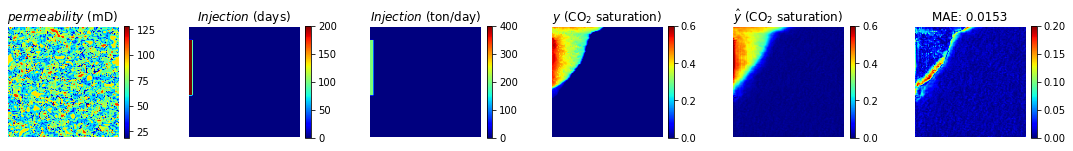

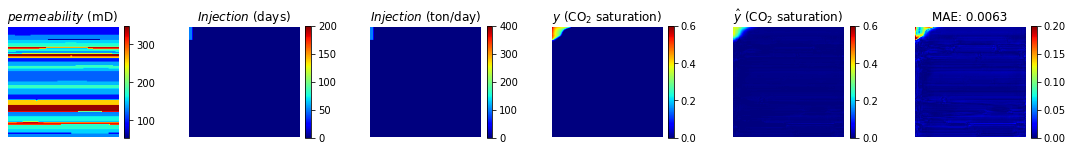

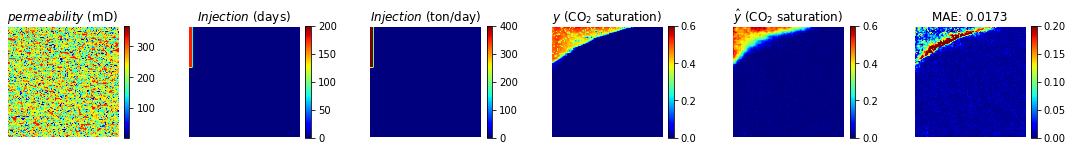

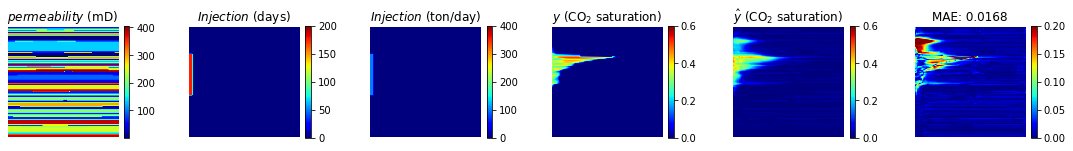

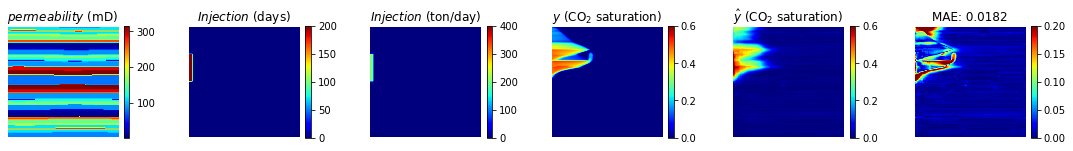

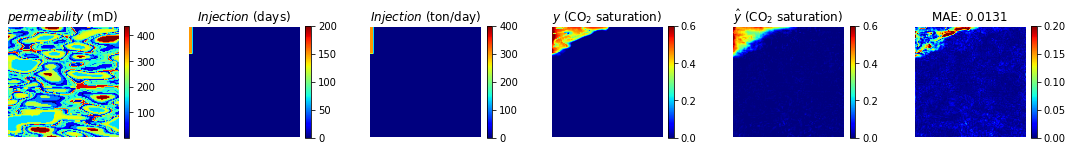

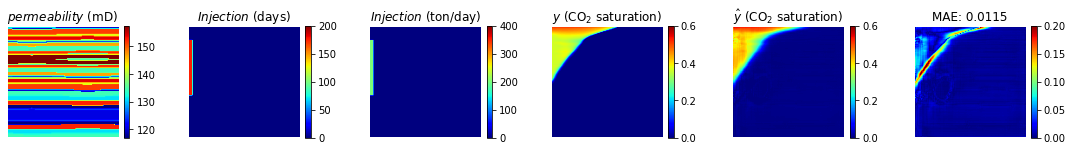

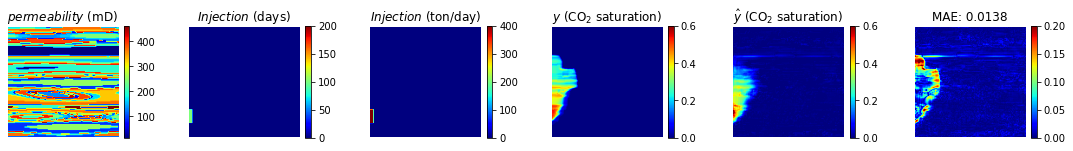

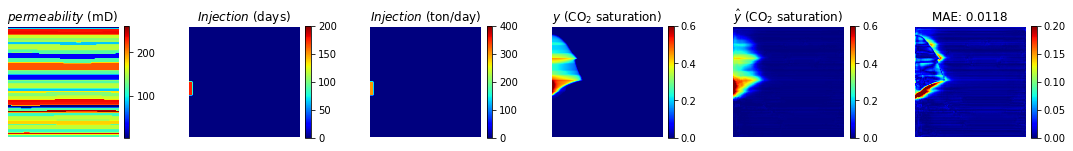

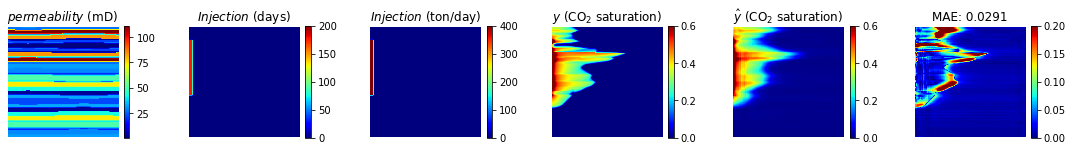

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')
for k in range(0,10):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,6,1)
    plt.title('$permeability$ (mD)')
    plt.imshow(inputs[k, 0, :, :].cpu() * 1000)
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,2)
    plt.title('$Injection$ (days)')
    plot_day = inputs[k, 1, :, :].cpu() * 200
    plot_day[:,1:4] = plot_day[:,0].reshape(128,1)
    plt.imshow(plot_day)
    plt.clim([0, 200])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,3)
    plt.title('$Injection$ (ton/day)')
    plot_rate = inputs[k, 2, :, :].cpu() * 400
    plot_rate[:,1:4] = plot_rate[:,0].reshape(128,1)
    plt.imshow(plot_rate)
    plt.clim([0, 400])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,4)
    plt.title('$y$ (CO$_2$ saturation)')
    plt.imshow(targets[k, 0, :, :].reshape(128, 128).cpu())
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,5)
    plt.imshow(outputs[k, 0, :, :].detach().cpu().numpy().reshape(128, 128))
    plt.title('$\hat{y}$ (CO$_2$ saturation)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,6)
    abs_err = np.abs((outputs[k, 0, :, :] - targets[k, 0, :, :]).detach().cpu().numpy())
    plt.imshow(abs_err) 
    mean_err = np.mean(abs_err)
    plt.title('MAE: %.4f' % mean_err)
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
    plt.tight_layout()
    plt.axis('off')
    plt.show()
